<a href="https://colab.research.google.com/github/sergiogarciag/hado/blob/main/sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python

In [ ]:
!pip install  plotly plotly-orca

ERROR: Could not find a version that satisfies the requirement plotly-orca (from versions: none)
ERROR: No matching distribution found for plotly-orca


In [ ]:
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.6 MB/s eta 0:00:00


In [ ]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install pmdarima
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install skforecast

In [ ]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")


Versión skforecast: 0.14.0
Versión pdarima: 2.0.4
Versión statsmodels: 0.14.4
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from google.colab import drive

drive.mount('/content/drive')

municipio = '39075'
municipio = '03031'
municipio = '24089'


def cargar_municipio(municipio, provincia):
  with open('/content/drive/My Drive/UNIRTFM/data/pernoctaciones/'+municipio+'.csv', 'r') as f:
    dfPernoctas = pd.read_csv(f, sep='|' , header=0, names=['date','origen', 'destino','y'])
    dfPernoctas['date'] = pd.to_datetime(dfPernoctas['date'], format='%Y%m%d', errors='coerce')
    #dfPernoctas = dfPernoctas.drop('date', axis=1)
    dfPernoctas = dfPernoctas[dfPernoctas['destino'] ==municipio]
    dfPernoctas = dfPernoctas[~dfPernoctas['origen'].astype(str).str.startswith(municipio[0:2])]
    dfPernoctas_grouped = dfPernoctas.groupby(['date','destino'])['y'].sum().reset_index()
    dfPernoctas_grouped.head()
    #dfPernoctas_grouped['mes'] = dfPernoctas_grouped['ds'].dt.month
    #dfPernoctas_grouped['anio'] = dfPernoctas_grouped['ds'].dt.year
    #dfPernoctas_grouped['diasemana'] = dfPernoctas_grouped['ds'].dt.dayofweek
    dfPernoctas_grouped['findesemana'] = np.logical_or(dfPernoctas_grouped['date'].dt.dayofweek == 5, dfPernoctas_grouped['date'].dt.dayofweek == 6).astype(int)
    #dfPernoctas_grouped.set_index('ds', inplace=True)
    dfPernoctas_grouped = dfPernoctas_grouped.drop('destino', axis=1)
    return dfPernoctas_grouped


datos = cargar_municipio(municipio, '')
datos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,y,findesemana
0,2022-01-01,12574.186,1
1,2022-01-02,12092.755,1
2,2022-01-03,8725.976,0
3,2022-01-04,8103.817,0
4,2022-01-05,7756.486,0
...,...,...,...
899,2024-06-26,6346.101,0
900,2024-06-27,6246.776,0
901,2024-06-28,6821.965,0
902,2024-06-29,10361.256,1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test estacionariedad serie original
-------------------------------------
ADF Statistic: -5.549438173389252, p-value: 1.6324660286605805e-06
KPSS Statistic: 0.22472703054839432, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------


<ipython-input-10-139c43d75b77>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(datos['y'])


ADF Statistic: -8.710127303382555, p-value: 3.6099882661911155e-14
KPSS Statistic: 0.41423212661413333, p-value: 0.07102063508011494

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -15.694602286640551, p-value: 1.4201797537566787e-28
KPSS Statistic: 0.0627346005961294, p-value: 0.1


<ipython-input-10-139c43d75b77>:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(datos_diff_2)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib.

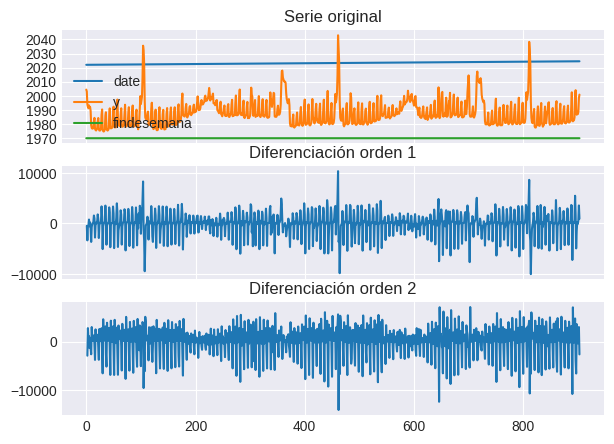

In [ ]:
datos_diff_1 = datos['y'].diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos['y'])
kpss_result = kpss(datos['y'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos_diff_1)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos_diff_2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

In [ ]:
# seleccionamos d = 0 para el modelo arima porque p(adfuller) es muy bajo.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


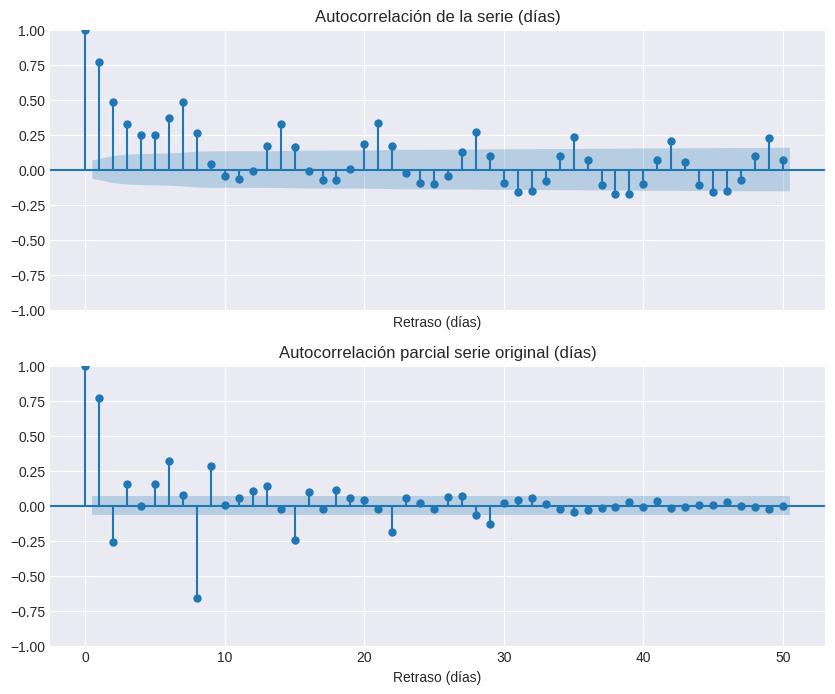

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
plot_acf(datos['y'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación de la serie (días)')
axs[0].set_xlabel('Retraso (días)')

plot_pacf(datos['y'], ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación parcial serie original (días)')
axs[1].set_xlabel('Retraso (días)')
filename = '/content/drive/My Drive/UNIRTFM/figuras/acfpacf' + municipio + '.png'
plt.savefig(filename)


In [ ]:
# patron periódico, sugiere estacionalidad, hay que incluir ordenes estsacionales

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


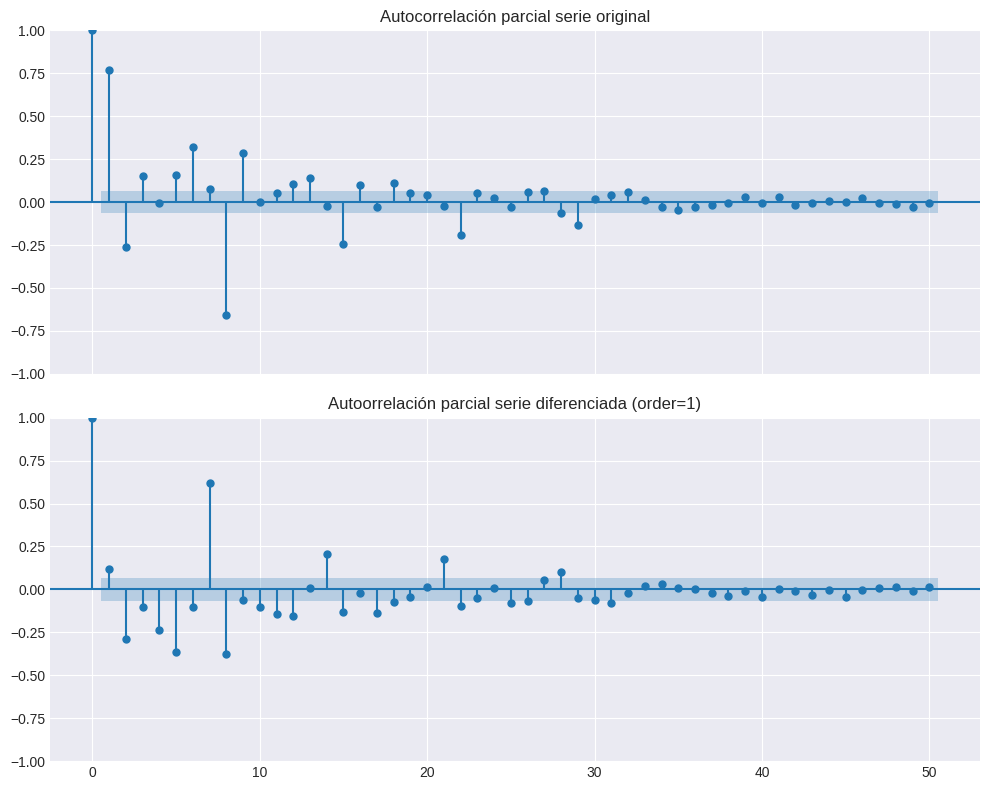

In [ ]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
plot_pacf(datos['y'], ax=axs[0],lags=50
          ,alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


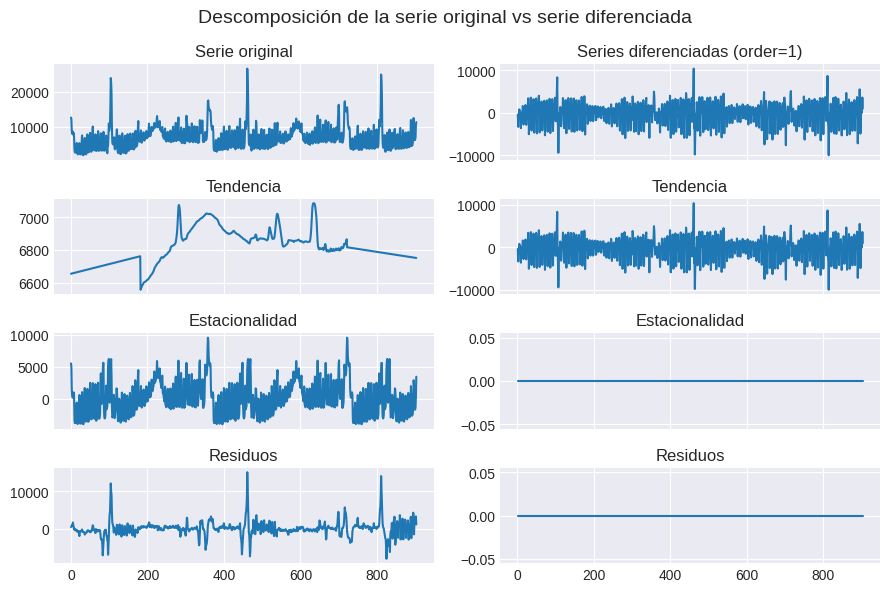

In [ ]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(datos['y'], period=364, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, period=1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [ ]:
def plot_components(result):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Datos originales', 'season':'Estacional','observed':'Dato Real','trend':'Tendencia',
                          'seasonal_7':'Semanal','seasonal_365':'Anual','resid':'Residuo'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])

# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Descomposición de la serie temporal para municipio '+ municipio,
      xaxis_title='Tiempo (días)',
      height=1200,
      width=1200
  )
  filename = '/content/drive/My Drive/UNIRTFM/figuras/descomposicionMSTL_' + municipio + '.png'
  fig.write_image(filename)
  fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
period = 364  #setting the period for decomposition
# Apply seasonal_decompose
result_sd = seasonal_decompose(datos['y'], model='additive', period=period, extrapolate_trend=1)

# Plot the results
plot_components(result_sd)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen im

In [ ]:
stl = STL(datos['y'], period=period)
result_stl = stl.fit()

# Plot the results
plot_components(result_stl)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
mstl = MSTL(datos['y'], periods=[7, 365])
result_mstl = mstl.fit()
plot_components(result_mstl)

In [ ]:
%%script echo no ejecutar
datos_diff_1_364 = datos['y'].diff().diff(364).dropna()

mstl = MSTL(datos_diff_1_364, periods=[7, 364])
result_mstl = mstl.fit()

# Plot the results
plot_components(result_mstl)

no ejecutar


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# %%script echo skipping
start = 730
steps = 7
folds = 20
maes = []
result = ''

for p in range(2):
  for q in range(2):
    for P in range(2):
      for Q in range(2):
        for d in range(1):
          for D in range(1):
            maes = []
            start = 730
            for i in range(folds):
              modelo = Sarimax(order=(p, d,  q), seasonal_order=(P,D,Q,7))
              start = start + steps
              modelo.fit(y=datos['y'].iloc[:start])
              predicciones_skforecast = modelo.predict(steps=steps)
              maes.append(mean_absolute_error(datos['y'].iloc[start:start+steps], predicciones_skforecast))
            result= result+'('+str(p)+','+str(d)+','+str(q)+') ('+str(P)+','+str(D)+','+str(Q)+',7) MAE: ' + str(np.mean(maes))+'\n'
            print(result)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(0,0,0) (0,0,0,7) MAE: 5729.443749999999

(0,0,0) (0,0,0,7) MAE: 5729.443749999999
(0,0,0) (0,0,1,7) MAE: 3932.9898243877738

(0,0,0) (0,0,0,7) MAE: 5729.443749999999
(0,0,0) (0,0,1,7) MAE: 3932.9898243877738
(0,0,0) (1,0,0,7) MAE: 1918.8622780556284

(0,0,0) (0,0,0,7) MAE: 5729.443749999999
(0,0,0) (0,0,1,7) MAE: 3932.9898243877738
(0,0,0) (1,0,0,7) MAE: 1918.8622780556284
(0,0,0) (1,0,1,7) MAE: 2069.462269734039



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-inve

(0,0,0) (0,0,0,7) MAE: 5729.443749999999
(0,0,0) (0,0,1,7) MAE: 3932.9898243877738
(0,0,0) (1,0,0,7) MAE: 1918.8622780556284
(0,0,0) (1,0,1,7) MAE: 2069.462269734039
(0,0,1) (0,0,0,7) MAE: 5348.339965916004



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-inve

(0,0,0) (0,0,0,7) MAE: 5729.443749999999
(0,0,0) (0,0,1,7) MAE: 3932.9898243877738
(0,0,0) (1,0,0,7) MAE: 1918.8622780556284
(0,0,0) (1,0,1,7) MAE: 2069.462269734039
(0,0,1) (0,0,0,7) MAE: 5348.339965916004
(0,0,1) (0,0,1,7) MAE: 3758.3479882765155



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-inve

In [ ]:
%%markdown

 (0,0,0) (0,0,0,7) MAE: 5769.463157142856
(0,0,0) (0,1,0,7) MAE: 2350.1943999999994
(0,1,0) (0,0,0,7) MAE: 4151.454528571428
(0,1,0) (0,1,0,7) MAE: 4156.287578571429
(0,0,0) (0,0,1,7) MAE: 4701.989849480022
(0,0,0) (0,1,1,7) MAE: 2059.6108963780885
(0,1,0) (0,0,1,7) MAE: 4346.494490841786
(0,1,0) (0,1,1,7) MAE: 3119.98901817429
(0,0,0) (1,0,0,7) MAE: 2628.8851011173456
(0,0,0) (1,1,0,7) MAE: 2058.5686698409218
(0,1,0) (1,0,0,7) MAE: 3742.6893934560735
(0,1,0) (1,1,0,7) MAE: 4002.0432618688383
(0,0,0) (1,0,1,7) MAE: 2006.6439793806173
(0,0,0) (1,1,1,7) MAE: 2296.3307539570164
(0,1,0) (1,0,1,7) MAE: 3109.802206977569
(0,1,0) (1,1,1,7) MAE: 3281.2452919132693
(0,0,1) (0,0,0,7) MAE: 5549.461706481188
(0,0,1) (0,1,0,7) MAE: 2446.9254463334473
(0,1,1) (0,0,0,7) MAE: 4421.919509723847
(0,1,1) (0,1,0,7) MAE: 4046.2791093935184
(0,0,1) (0,0,1,7) MAE: 4560.628900881874
(0,0,1) (0,1,1,7) MAE: 2108.783726821263
(0,1,1) (0,0,1,7) MAE: 4384.040642957789
(0,1,1) (0,1,1,7) MAE: 3141.9612063170816
(0,0,1) (1,0,0,7) MAE: 2737.809753985629
(0,0,1) (1,1,0,7) MAE: 2063.5531455819787
(0,1,1) (1,0,0,7) MAE: 3740.9765631923647
(0,1,1) (1,1,0,7) MAE: 3927.3046752713535
(0,0,1) (1,0,1,7) MAE: 2684.151407192473
(0,0,1) (1,1,1,7) MAE: 2087.515282913896
(0,1,1) (1,0,1,7) MAE: 3374.29686927509
(0,1,1) (1,1,1,7) MAE: 3459.270327235218
(1,0,0) (0,0,0,7) MAE: 3698.768869836413
(1,0,0) (0,1,0,7) MAE: 3175.791913555095
(1,1,0) (0,0,0,7) MAE: 4308.4169278801255
(1,1,0) (0,1,0,7) MAE: 3855.8169201158466
(1,0,0) (0,0,1,7) MAE: 3692.2652453464457
(1,0,0) (0,1,1,7) MAE: 2290.8263641139633
(1,1,0) (0,0,1,7) MAE: 4348.29485697107
(1,1,0) (0,1,1,7) MAE: 3132.8785470548037
(1,0,0) (1,0,0,7) MAE: 3291.0994644482257
(1,0,0) (1,1,0,7) MAE: 2883.3192131017427
(1,1,0) (1,0,0,7) MAE: 3579.371624573129
(1,1,0) (1,1,0,7) MAE: 3677.1363060281183
(1,0,0) (1,0,1,7) MAE: 2229.2247119924295
(1,0,0) (1,1,1,7) MAE: 2380.690275944618
(1,1,0) (1,0,1,7) MAE: 3366.8447574103
(1,1,0) (1,1,1,7) MAE: 3442.8283509202556
(1,0,1) (0,0,0,7) MAE: 3831.056538957075
(1,0,1) (0,1,0,7) MAE: 2911.0530280123485
(1,1,1) (0,0,0,7) MAE: 4116.129811994759
(1,1,1) (0,1,0,7) MAE: 4015.192029199946
(1,0,1) (0,0,1,7) MAE: 3653.9840439049062
(1,0,1) (0,1,1,7) MAE: 2121.0376607457247
(1,1,1) (0,0,1,7) MAE: 4410.844519610393
(1,1,1) (0,1,1,7) MAE: 2871.6217225888618
(1,0,1) (1,0,0,7) MAE: 3146.072107778453
(1,0,1) (1,1,0,7) MAE: 2628.6444090942487
(1,1,1) (1,0,0,7) MAE: 3694.855092023153
(1,1,1) (1,1,0,7) MAE: 3914.53170147236
(1,0,1) (1,0,1,7) MAE: 2777.903568807202
(1,0,1) (1,1,1,7) MAE: 2241.738116726655



In [ ]:
def cargar_meteo(municipio):
  with open('/content/drive/My Drive/UNIRTFM/data/meteo/'+municipio+'.csv', 'r') as f:
    dfMeteo = pd.read_csv(f, sep=',' , encoding='iso-8859-1')
    dfMeteo['claro'] = (dfMeteo['icon'] == 'clear-day').astype(int)
    dfMeteo['precipitacion'] = np.logical_or(dfMeteo['icon'] == 'rain' , dfMeteo['icon'] == 'snow').astype(int)
    dfMeteo['cubierto'] = np.logical_or(dfMeteo['icon'] == 'partly-cloudy-day' , dfMeteo['icon'] == 'cloudy').astype(int)
    dfMeteo = dfMeteo.drop(['tempmax',	'tempmin','precip','precipprob','precipcover',	'preciptype'	,'cloudcover','icon'], axis=1)
    return dfMeteo


dfmeteo = cargar_meteo(municipio)



In [ ]:
dfmeteo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Unnamed: 0,datetime,temp,claro,precipitacion,cubierto
0,0,2022-01-01,6.1,0,0,1
1,1,2022-01-02,6.5,0,0,1
2,2,2022-01-03,3.6,0,0,1
3,3,2022-01-04,4.5,0,1,0
4,4,2022-01-05,0.5,0,1,0
...,...,...,...,...,...,...
1030,1030,2024-10-27,5.9,0,1,0
1031,1031,2024-10-28,11.7,0,0,1
1032,1032,2024-10-29,12.8,0,0,1
1033,1033,2024-10-30,13.6,0,1,0


In [ ]:
diasvacaciones = pd.read_csv('/content/drive/My Drive/UNIRTFM/data/diasvacaciones.csv')
diasvacaciones

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,date,vacaciones
0,2022-01-01,1
1,2022-01-02,0
2,2022-01-03,0
3,2022-01-04,0
4,2022-01-05,0
...,...,...
1091,2024-12-27,1
1092,2024-12-28,1
1093,2024-12-29,1
1094,2024-12-30,1


In [ ]:
exog = pd.concat([dfmeteo[['temp', 'claro', 'precipitacion', 'cubierto']]    , datos[['findesemana']], diasvacaciones[['vacaciones']]], axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
exog

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,temp,claro,precipitacion,cubierto,findesemana,vacaciones
0,6.1,0.0,0.0,1.0,1.0,1
1,6.5,0.0,0.0,1.0,1.0,0
2,3.6,0.0,0.0,1.0,0.0,0
3,4.5,0.0,1.0,0.0,0.0,0
4,0.5,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...
1091,NaN,NaN,NaN,NaN,NaN,1
1092,NaN,NaN,NaN,NaN,NaN,1
1093,NaN,NaN,NaN,NaN,NaN,1
1094,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# 39075 (0,0,1) (1,0,1,7) MAE: 2308.492215201662

p=0
d=0
q=0
P=1
D=0
Q=1
start = 730
folds=10
steps=14
maes = []
mapes = []
prediccion = pd.DataFrame()

for i in range(folds):

  modelo = Sarimax(order=(p, d,  q), seasonal_order=(P,D,Q, 7))


  modelo.fit(y=datos['y'].iloc[:start],exog=exog[['precipitacion','claro','cubierto','temp','findesemana','vacaciones']].iloc[:start])
  predicciones_skforecast = modelo.predict(steps=steps,exog=exog[['precipitacion','claro','cubierto','temp','findesemana','vacaciones']].iloc[start:start+steps])

  maes.append(mean_absolute_error(datos['y'].iloc[start:start+steps], predicciones_skforecast))
  mapes.append(mean_absolute_percentage_error(datos['y'].iloc[start:start+steps], predicciones_skforecast))
  start = start + steps


result= '('+str(p)+','+str(d)+','+str(q)+') ('+str(P)+','+str(D)+','+str(Q)+',7) MAPEs: ' + str(np.mean(mapes))+'\n'

print(result)

mape =np.mean(mapes)
mape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(0,0,0) (1,0,1,7) MAPEs: 0.4868344588995196



0.4868344588995196

In [ ]:
mape

0.3972121746724767

In [ ]:
import os
from datetime import datetime

def guardar_mape(metodo, municipio, mape):
  """Guarda el MAPE en un archivo CSV.

  Args:
    metodo: El método utilizado para calcular el MAPE.
    municipio: El municipio al que corresponde el MAPE.
    mape: El valor del MAPE.
  """
  timestamp_ejecucion = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  file_path = '/content/drive/My Drive/UNIRTFM/resultados/mape.csv'

  if os.path.exists(file_path):
    df = pd.read_csv(file_path)
  else:
    df = pd.DataFrame(columns=['metodo', 'municipio', 'timestamp_ejecucion', 'mape'])

  new_data = pd.DataFrame({'metodo': [metodo],
                            'municipio': [municipio],
                            'timestamp_ejecucion': [timestamp_ejecucion],
                            'mape': [mape]})

  df = pd.concat([df, new_data], ignore_index=True)
  df.to_csv(file_path, index=False)

# Ejemplo de uso (reemplaza con tus valores reales)
guardar_mape("SARIMAX", municipio, mape)

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



In [ ]:
filename_csv = '/content/drive/My Drive/UNIRTFM/resultados/sarimax' + municipio + '.csv'
prediccion.to_csv(filename_csv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



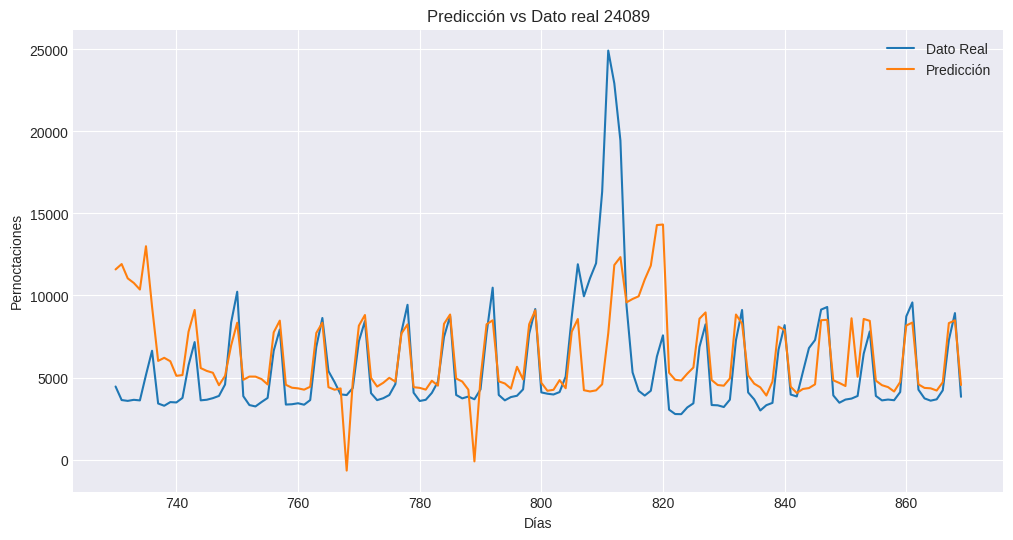

In [ ]:

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(datos['y'].iloc[730:730+folds*steps], label='Dato Real')
plt.plot(prediccion, label='Predicción')
plt.xlabel('Días')
plt.ylabel('Pernoctaciones')
plt.title('Predicción vs Dato real '+ municipio)
plt.legend()
plt.grid(True)
filename = '/content/drive/My Drive/UNIRTFM/figuras/sarimax' + municipio + '.png'
plt.savefig(filename)
plt.show()